### Collecting Training Data
In order to start collecting training data, you'll need to do the following:

* Enter Training Mode in the simulator.
* Start driving the car to get a feel for the controls.
* When you are ready, hit the record button in the top right to start recording.
* Continue driving for a few laps or till you feel like you have enough data.
* Hit the record button in the top right again to stop recording.

### Strategies for Collecting Data
Now that you have driven the simulator and know how to record data, it's time to think about collecting data that will ensure a successful model. There are a few general concepts to think about that we will later discuss in more detail:

* the car should stay in the center of the road as much as possible
* if the car veers off to the side, it should recover back to center
* driving counter-clockwise can help the model generalize
* flipping the images is a quick way to augment the data
* collecting data from the second track can also help generalize the model
* we want to avoid overfitting or underfitting when training the model
* knowing when to stop collecting more data




### 1.Image augmentation

#### 1.1 Center and lateral images
So, we have data from lateral cameras. But what to do with it?
Following a suggestion from the great carND forum (by the way, almost all of these tips are from there), I added a correction angle of 0.10 to the left image, and -0.10 to the right one. The idea is to centre the car, avoid the borders.

#### 1.2 Flip images
Another excellent tip. We can randomly choose to flip the image, and invert the steering angle. This way, we can neutralize some tendency of the human driver that drove a bit more to the left or to the right of the lane.

    if np.random.uniform()>0.5:
      X_in[i,:,:,:] = cv2.flip(X_in[i,:,:,:],1)
      Y_in[i] = -p[i] #Flipped images

Be careful to use the function correctly. Flip with parameter zero will do a wrong thing.

#### 1.3 Random lateral perturbation
The idea is to move to image a randomly a bit to the left or the right, and add a proportional compensation in the angle value. In the end, I didn’t used this approach, but it is a good idea.

    pix2angle = -0.05 #Opposed direction
    latShift = random.randint(-5,5) 
    M = np.float32([[1,0,latShift],[0,1,0]])
    imgTranslated = cv2.warpAffine(img,M,(img.shape[1],img.shape[0]))

#### 1.4 Resize
Because of computational limits, it is a good thing to resize the images, after cropping it. Using the size of NVIDIA paper (66 x 200 pixels) my laptop went out of memory. I tried (64 x 64), (64 x 96), (64 x 128)…
I also reduced the size of the stride of the convolutional layers. Since the image is smaller, the stride can also be smaller.

    X_in[i,:,:,0] = cv2.resize(imgScreenshots[i].squeeze(), (size2,size1))

All of these sizes work. An curious effect. When the image is smaller, the zig zag of the car is greater. Surely because there are fewer details in the image.

#### 1.5 Crop
The image was cropped to remove irrelevant portions of the image, like the sky, or the trees. Doing this, we’re assuming the camera is fixed in a stable position.

Because inside the model a image is just a matrix, a numpy command easily do this operation.

    crop_img = imgRGB[40:160,10:310,:] #Throwing away to superior portion of the image and 10 pixels from each side of the original image = (160, 320)
    
It makes sense to do the transformations (like the lateral shift) before the cropping, since we’re losing information. Doing the opposite, we will feed the model with an image with a lateral black bar.

#### 1.6 Grayscale, YUV, HSV
I tried grayscale, full color, the Y channel of YUV, S channel of HSV…
All of this because my model wasn’t able to avoid the dirty exit after the bridge, where there is not a clear lane mark in the road.
Some conversion commands:

    imgOut = cvtColor(img, cv2.COLOR_BGR2YUV) 
    imgOut = cvtColor(img, cv2.COLOR_BGR2HSV)

But the real problem was that OpenCV (cv2.imread command) reads a image in BGR, and the code in drive.py, in RGB.
I used the conversion command of opencv to transform the image in RGB.

    imgOut = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
The model used full color RGB. In addition to it, I used a first layer of the NN that just transform the 3 color channels in 1 channel, with the ponderation Keras chooses, instead of me choosing the right channel.

    model.add(Convolution2D(1,1,1, border_mode = ‘same’,init =’glorot_uniform’,input_shape=(size1,size2,3)))


#### 1.7 Normalization
Normalization is made because the neural network usually works with small numbers: sigmoid activation has range (0, 1), tanh has range (-1,1).
Images have 3 channels (Red, Green, Blue), each channel has value 0 to 255. The normalized array has range from -1 to 1.

    X_norm = X_in/127.5–1

---

### 2. Neural Networks
#### 2.1 Architecture
Once the image processing and augmentation is done, it is time to design the Neural Network (NN) . But there are an infinite number of architectures of neural networks.
As a starting point, I used the NVIDIA End-to-End model (https://arxiv.org/abs/1604.07316), that has the configuration described below.

![](./images/cnn-architecture-624x890.png)
>CNN architecture. The network has about 27 million connections and 250 thousand parameters.

We can broadly describe the tasks of the NN in two: recognize relevant features and predict the steering angle.
The recognition of features is carried by convolutional layer

What is a convolution?
A convolution operation is like a window that slides across the image and does a dot product. It works as a recognizer of some feature. For example, if the convolution of a triangle, the portion of the image that has that triangle will have maximum value, while some totally uncorrelated image will have minimum value.

![](./images/convolution.gif)

**Why so many convolutional layers?**
Each convolutional layer is a level of abstraction above the previous layer. As an analogy, the first layer recognizes the parts of a car, the second layer recognizes the car, the third layer recognizes the scenario with the car, and so on.
It is important to stress that we do not give the explicit features the image has to recognize. It is automatically done by the back-propagation of the neural network. It has some pros and cons. The pro is that we just feed the network. The con is that if it not work, we don’t have idea of why it didn’t work — is the network too small? Too big?

**Given the features, how to decide about the steering angle?**
It is done by **fully connected layers** after the convolutional ones.
The matrix is flattened, because the spatial information of rows and columns doesn’t matter any longer. The NN is like a function that is feed with images, and for each image, give the steering angle as steering angle, which is compared to the angle of the human driver.
Another thing to note is that these techniques are very new. Much of these concepts are not well understood and consolidated. It is at the same time good, because we are at the frontier of knowledge, and scary, because sometimes we simply don’t know if something works or not.

#### 2.2 Loss error function








pip install --upgrade --ignore-installed setuptools

pip install python-socketio

python drive.py model.h5

python drive.py model.h5 run1

python video.py run1

python video.py run1 --fps 48

https://developer.nvidia.com/cuda-10.0-download-archive?target_os=Windows&target_arch=x86_64&target_version=10&target_type=exelocal

https://www.geforce.cn/drivers


In [1]:
import keras
import tensorflow as tf

print(keras.__version__)#2.2.4
print(tf.__version__)#2.0.0

Using TensorFlow backend.


2.3.1
2.0.0


In [1]:
#Keras强制使用CPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [1]:
import csv
import cv2
import numpy as np
import os
from math import ceil 
from PIL import Image

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Conv2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.models import Model
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


samples=[]
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
        
        
'''
images = []
measurements = []
for line in lines:
    for i in range(3):#center,left,right
        source_path = line[i]
#         filename = source_path.split('/')[-1]
        filename = source_path.split('\\')[-1]
        current_path = './data/IMG/'+filename
        if(os.path.exists(current_path)):
            image = cv2.imread(current_path)
            images.append(image)
            measurement = float(line[3])
            measurements.append(measurement)
'''

'''
#Data augmentation        
augmented_images, augmented_measurements = [],[]
for image, measurement in zip(images, measurements):
    augmented_images.append(image)
    augmented_measurements.append(measurement)
    augmented_images.append(cv2.flip(image, 1))
    augmented_measurements.append(measurement*-1.0)


X_train = np.array(augmented_images)
y_train = np.array(augmented_measurements)
'''

########################################################################
#Model Architecture
########################################################################
#Use Keras to train a network to do the following:
#1.Take in an image from the center camera of the car. This is the input to your neural network.
#2.Output a new steering angle for the car. 

model = Sequential()
#Set up lambda layer
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160, 320, 3)))
#Cropping2D Layer
# model.add(Cropping2D(cropping=((70,25),(0,0))))
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))

model.add(Conv2D(24, (5, 5), strides=(2, 2), activation="relu"))
model.add(Conv2D(36, (5,5), strides=(2,2), activation="relu"))
model.add(Conv2D(48, (5,5), strides=(2,2), activation="relu"))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(Conv2D(64, (3,3), activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

#LeNet
# model.add(Convolution2D(6, 5, 5, activation="relu"))
# model.add(MaxPooling2D())
# model.add(Convolution2D(6, 5, 5, activation="relu"))
# model.add(MaxPooling2D())
# model.add(Flatten())
# model.add(Dense(120))
# model.add(Dense(84))
# model.add(Dense(1))

########################################################################
#Data augmentation        
########################################################################
def data_augment(images, measurements):
    augmented_images, augmented_measurements = [],[]
    for image, measurement in zip(images, measurements):
        augmented_images.append(image)
        augmented_measurements.append(measurement)
        augmented_images.append(cv2.flip(image, 1))
        augmented_measurements.append(measurement*-1.0)

    return augmented_images,augmented_measurements

########################################################################
#Generator
########################################################################
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for row in batch_samples:
                '''
                for i in range(3):#center,left,right
                    source_path = batch_sample[i]
            #         filename = source_path.split('/')[-1]
                    filename = source_path.split('\\')[-1]
                    current_path = './data/IMG/'+filename
                    if(os.path.exists(current_path)):
#                         image = cv2.imread(current_path)
#                         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        image = Image.open(current_path)
                        images.append(image)
                        measurement = float(line[3])
                        angles.append(measurement)
                '''
                steering_center = float(row[3])

                # create adjusted steering measurements for the side camera images
                correction = 0.2 # this is a parameter to tune
                steering_left = steering_center + correction
                steering_right = steering_center - correction

                # read in images from center, left and right cameras
                path = "./data/IMG/" # fill in the path to your training IMG directory
                img_center = np.asarray(Image.open(path + row[0].split('\\')[-1]))
                img_left = np.asarray(Image.open(path + row[1].split('\\')[-1]))
                img_right = np.asarray(Image.open(path + row[2].split('\\')[-1]))

                # add images and angles to data set
                images.append(img_center)
                images.append(img_left)
                images.append(img_right)
                angles.append(steering_center)
                angles.append(steering_left)
                angles.append(steering_right)
#                 images.extend(img_center, img_left, img_right)
#                 angles.extend(steering_center, steering_left, steering_right)

            augmented_images, augmented_measurements = data_augment(images, angles)
            X_train = np.array(augmented_images)
            y_train = np.array(augmented_measurements)
            yield sklearn.utils.shuffle(X_train, y_train)
            
            
########################################################################
########################################################################
train_samples, validation_samples = train_test_split(samples, test_size=0.3)

batch_size = 32

#Compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)          
          
model.summary()   

model.compile(loss='mse', optimizer='adam')
# model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=5)
history_object = model.fit_generator(train_generator, 
                                     steps_per_epoch=ceil(len(train_samples)/batch_size),
                                     validation_data=validation_generator, 
                                     validation_steps=ceil(len(validation_samples)/batch_size), 
                                     epochs=5, verbose=1)



model.save("model.h5")
          
          
          

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 43, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 37, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 35, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 33, 64)        

dict_keys(['val_loss', 'loss'])


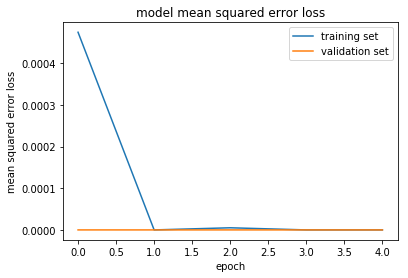

In [2]:
# history_object = model.fit_generator(train_generator, samples_per_epoch =
#     len(train_samples), validation_data = 
#     validation_generator,
#     nb_val_samples = len(validation_samples), 
#     nb_epoch=5, verbose=1)

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

## More Data Collection
Here are some general guidelines for data collection:

* two or three laps of center lane driving
* one lap of recovery driving from the sides
* one lap focusing on driving smoothly around curves



